Pruebas en el modelo v6

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import _init_paths

import os

import torch
import torch.utils.data
from opts import opts
from models.model import create_model, load_model, save_model
from models.data_parallel import DataParallel
from logger import Logger
from datasets.dataset_factory import get_dataset
from trains.train_factory import train_factory
import cv2
import sys
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
sys.argv = ['-f', 'ctdetv2', '--exp_id', 'coco_dlav6','--num_workers', '0','--batch_size','2', '--arch','dlav6_34',  '--load_model' ,'../exp/ctdetv2/coco_dlav6/model_last_.pth'] #cmd = 'ctdet --exp_id coco_dla --batch_size 4 --lr 1.25e-4  --gpus 0 --num_workers 0'
opt = opts().parse()
print(opt.task)
print(opt.num_workers)
print(opt.batch_size)

Fix size testing.
training chunk_sizes: [2]
The output will be saved to  C:\Users\avata\FewShot-CenterNet\src\lib\..\..\exp\ctdetv2\coco_dlav6
ctdetv2
0
2


In [3]:
torch.manual_seed(opt.seed)
torch.backends.cudnn.benchmark = not opt.not_cuda_benchmark and not opt.test

In [4]:
Dataset = get_dataset(opt.dataset, opt.task)
opt = opts().update_dataset_info_and_set_heads(opt, Dataset)
logger = Logger(opt)
os.environ['CUDA_VISIBLE_DEVICES'] = opt.gpus_str
opt.device = torch.device('cuda' if opt.gpus[0] >= 0 else 'cpu')

heads {'hm': 80, 'wh': 2, 'reg': 2}


In [5]:
model = create_model(opt.arch, opt.heads, opt.head_conv)
optimizer = torch.optim.Adam(model.parameters(), opt.lr)
start_epoch = 0
if opt.load_model != '':
    model, optimizer, start_epoch = load_model(model, opt.load_model, optimizer, opt.resume, opt.lr, opt.lr_step)

loaded ../exp/ctdetv2/coco_dlav6/model_last_.pth, epoch 12


In [6]:
Trainer = train_factory[opt.task]
trainer = Trainer(opt, model, optimizer)
trainer.set_device(opt.gpus, opt.chunk_sizes, opt.device)

In [7]:
train_loader = torch.utils.data.DataLoader(
      Dataset(opt, 'train'), 
      batch_size=opt.batch_size, 
      shuffle=True,
      num_workers=opt.num_workers,
      pin_memory=True,
      drop_last=True
  )

==> initializing coco 2017 train data.
loading annotations into memory...
Done (t=14.45s)
creating index...
index created!
Loaded train 118287 samples


In [37]:
img = next(iter(train_loader))

In [38]:
print(img.keys())
print(img['input'].size())

dict_keys(['input', 'hm', 'reg_mask', 'ind', 'wh', 'hm_mod', 'reg'])
torch.Size([2, 3, 512, 512])


In [39]:
model.to('cuda')
torch.cuda.empty_cache()
outputs = model(img['input'].to('cuda'))
output = outputs[0]
print(output.keys())

dict_keys(['objns', 'hm', 'wh', 'reg'])


In [40]:
batch=img
mask = batch['reg_mask']
ind = batch['ind']
target_wh = batch['wh']
target_reg = batch['reg']

In [41]:
pred_hm = output['hm'].sigmoid()
print(pred_hm.size())
gt_hm = batch['hm']
print(gt_hm.size())

torch.Size([2, 80, 128, 128])
torch.Size([2, 80, 128, 128])


C heatmaps summed
torch.Size([2, 80, 128, 128])
0.5999875


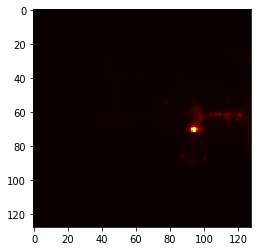

In [48]:
print('C heatmaps summed')
img_gt2 = pred_hm.detach().cpu().numpy()
img_r = img_gt2[0,0,:,:]
print(pred_hm.size())
print(img_r.max())
plt.imshow(img_r, cmap='hot', interpolation='nearest')

C heatmaps summed
torch.Size([2, 1, 128, 128])
tensor(0.7310, device='cuda:0', grad_fn=<MaxBackward1>)


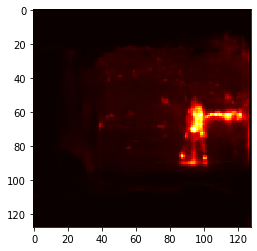

In [51]:
print('C heatmaps summed')
pred_obj = output['objns'].sigmoid()
img_gt2 = pred_obj.detach().cpu().numpy()
img_r = img_gt2[0,0,:,:]
print(pred_obj.size())
print(pred_obj.max())
plt.imshow(img_r, cmap='hot', interpolation='nearest')

In [44]:
(img_gt2.squeeze(1))


array([[[0.5004316 , 0.50002503, 0.50002503, ..., 0.50002503,
         0.50012124, 0.5001999 ],
        [0.50367147, 0.50002503, 0.50002503, ..., 0.50002503,
         0.50013036, 0.50005084],
        [0.5010059 , 0.50002503, 0.50002503, ..., 0.50002503,
         0.50002503, 0.50002503],
        ...,
        [0.5024259 , 0.5002544 , 0.5000506 , ..., 0.5017758 ,
         0.5102259 , 0.50077087],
        [0.5063275 , 0.5007975 , 0.50016004, ..., 0.5043974 ,
         0.5170625 , 0.50131166],
        [0.50315416, 0.5004127 , 0.50018877, ..., 0.50068307,
         0.5020506 , 0.5009823 ]],

       [[0.5586346 , 0.5279291 , 0.5251848 , ..., 0.5130843 ,
         0.51804996, 0.5035141 ],
        [0.5400772 , 0.5182054 , 0.5158757 , ..., 0.5039571 ,
         0.506315  , 0.50103265],
        [0.5459544 , 0.5246014 , 0.522763  , ..., 0.5082601 ,
         0.511268  , 0.5012708 ],
        ...,
        [0.50417113, 0.5013247 , 0.50085616, ..., 0.5016835 ,
         0.5030388 , 0.500236  ],
        [0.5

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


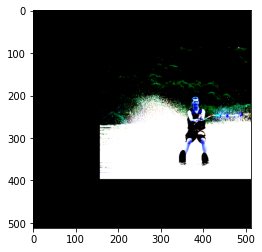

In [45]:
plt.imshow(img['input'][0].permute(1,2,0))

C heatmaps summed


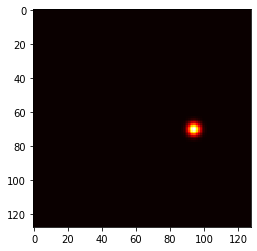

In [46]:
print('C heatmaps summed')
plt.imshow(gt_hm[0,0,:,:].detach().cpu().numpy(), cmap='hot', interpolation='nearest')

In [144]:
class_name = ['person', 'bicycle', 'car', 'motorcycle', 'airplane',
      'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant',
      'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
      'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack',
      'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
      'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
      'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass',
      'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
      'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
      'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv',
      'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave',
      'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase',
      'scissors', 'teddy bear', 'hair drier', 'toothbrush']

In [145]:
class_name[56]

'chair'